In [183]:
import numpy as np
import pandas as pd
import geopandas as gpd
import cartopy.feature as cfeature
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
from cartopy.feature import ShapelyFeature
from cartopy.io.shapereader import Reader
# from mpl_toolkits.basemap import Basemap, cm
import warnings
warnings.filterwarnings('ignore')

def analisis_calidad(serie, times_res):
    from itertools import groupby
    from datetime import date
    """ Mediante esta función realizamos un análisis de calidad de series
    
    Parameters:
    -----------
    serie: serie de datos que se quiere analizar. Se requiero que el index sea un Datetime
    
    times_res: 1 si son datos diarios, 24 sin son horarias y 144, introducir como Integer
    
    Serie: introducir la serie que se desea analizar"
    
    año_ini: introducir el año inicial a partir del cual se quiere realizar el análisis
    
    Output:
    -------
    n_años_completos: nº de años que contienen datos todos los días
    por_huecos: porcentaje de huecos de la serie en %
    n_años_con_dato: nº de años que contienen datos
    n_meses_completos: número de meses que contienen datos todos los días
    n_dias_completos: en el caso en que la resolución sea horaria, nº de días que contienen datos todos las horas
    año_inicio: año de inicio de la serie
    año_fin: año de fin de la serie """
    
    serie=serie.astype(np.float64)
    año_ini=serie.dropna().index.year[0]
    res=times_res
    data=serie[serie.index.year>=año_ini]
    global n_max_años_consecutivos
    if len(data)==0 or np.isnan(np.nanmax(data))==True:
        n_años_completos=np.nan
        por_huecos=np.nan
        n_años_con_dato=np.nan
        n_meses_completos=np.nan
        n_max_años_consecutivos=np.nan
        n_min_años_consecutivos=np.nan
        año_inicio=np.nan
        año_fin=np.nan
    else:
        año_inicio=np.min(serie.dropna().index.year.values)
        data=serie[serie.index.year>=año_inicio]
        d0 = data.index[0]
        d1 = data.index[-1]
        delta = d1 - d0
        data_0=data.copy()
        data_0[np.isnan(data_0)==False]=1
        data_1=data_0.resample('A').sum()
        data_2=data_0.resample('M').sum()
        porc_dias_meses=data_2.values.T/data_2.index.day.values
        n_años_completos=list(data_1.values).count(365*res)+list(data_1.values).count(366*res)
        por_huecos=(1-len(data.dropna())/delta.days)*100
        n_años_con_dato=np.sum(data_1.values>0)
        n_meses_completos=len(porc_dias_meses[porc_dias_meses==1])
        data_1[data_1<365*res]=np.nan
        data_1[data_1>=365*res]=1
        count_dups = np.array([sum(1 for _ in group) for _, group in groupby(list(data_1.values))])
#         n_min_años_consecutivos=np.min(count_dups)
#         n_max_años_consecutivos=np.max(count_dups)
        año_fin=np.max(serie.dropna().index.year.values)
        if res!=1:
            data_2=data_0.resample('D').sum()
            porc_horas_dias=data_2.values.T/24
            n_dias_completos=len(porc_horas_dias[porc_horas_dias==1])
            return(n_años_completos,por_huecos,n_años_con_dato,n_meses_completos,n_dias_completos,año_inicio,año_fin)
        else:
            return(n_años_completos,por_huecos,n_años_con_dato,n_meses_completos,año_inicio,año_fin)

def extract_data_GHC(selection,area,variable,path,path_output,country=False,export=False):
    """La selección se puede realizar de diferentes formas, seleccionando el país o introduciendo un area de extension
    
        Parameters:
        -----------
        selection: introducir "area" o "country"
        
        variable: variable que deseamos descargar "PRCP", "TAMAX", "TMIN",'TAVG'.
        
        area: En el caso de que se haga la selección a través de un área introducir las coordenadas de extensión [W,E,S,N], en caso
        contrario introducir False.
        
        path: lugar donde se encuentran los ficheros, se encuentran en G:/CLIMA/02_HYDRO-CLIMATE/GHC_Daily/
        
        path_output: luagar donde queremos guardar los ficheros extraidos.
        
        country: Introducir False en el caso en el que se seleccionen puntos a través de un área, en caso de que se introduzca 
        en selección "country", introducir las siglas del país que se encuentran en el fichero "ghcnd-countries.txt"
        
        export: True o False según se quiera exportar los datos o solo visualizar las estaciones.
        
        
        """
    countries=pd.read_csv(path+'ghcnd-countries.txt',delim_whitespace=True, error_bad_lines=False,header=None,warn_bad_lines=False)
    location=pd.read_csv(path+'ghcnd-inventory.txt',delim_whitespace=True, error_bad_lines=False,header=None,index_col=0,warn_bad_lines=False)
    location_2=location[location[3]==variable].copy()
    
    if selection=='area':
        station_area=location_2[(location_2[2]>=area[0])&(location_2[2]<=area[1])&(location_2[1]>=area[2])&(location_2[1]<=area[3])]
        station_area=station_area.iloc[:,0:2]
        station_area.columns=['Lat','Lon']
        station_area=pd.concat([station_area,pd.DataFrame(columns=['Name','Nª años completos','Porcentaje de huecos (%)','Nº años con dato',
                              'Nº meses completos','Año inicio','Año fin'])])
        fig, ax = plt.subplots(figsize=(14, 10),subplot_kw=dict(projection=ccrs.PlateCarree()))
        ax.add_feature(cfeature.COASTLINE.with_scale('10m'))
        ax.add_feature(cfeature.BORDERS.with_scale('10m'))
        ax.plot(station_area.loc[:,'Lon'].values,station_area.loc[:,'Lat'].values,'.r',markersize=2, label=variable)
        ax.legend(fontsize=12)
        if export==True:
            for i in station_area.index:
                data=pd.read_csv(path+'files/'+i+'.csv', index_col=1, parse_dates=True)
                station_area.loc[i,'Name']=data['NAME'][0]
                data=data.loc[:,variable]/10
                data_new=pd.DataFrame(index=pd.date_range(start=data.index[0],end=data.index[-1]),columns=[variable])
                data_new.loc[data.index,variable]=np.array(data.values,dtype=np.float64)
                station_area.loc[i,['Nª años completos','Porcentaje de huecos (%)','Nº años con dato',
                              'Nº meses completos','Año inicio','Año fin']]=analisis_calidad(pd.DataFrame(data_new), 1)
                data_new.to_csv(path_output+variable+'_'+i+'.csv',encoding='latin-1')
            station_area.to_csv(path_output+'Loc_stations_'+variable+'.csv',encoding='latin-1')
                    
    
    elif selection=='country':
        pos=np.where(countries.iloc[:,1]==country)[0]
        code=countries.iloc[pos,0].values
        code=code[0]
        list_station=list()

        for i in location_2.index:
            if code in i[:2]:
                list_station.append(i)
        station_country_loc=location_2.loc[list_station,:]
        station_country_loc=station_country_loc.iloc[:,0:2]
        station_country_loc.columns=['Lat','Lon']
        station_country_loc=pd.concat([station_country_loc,pd.DataFrame(columns=['Name','Nª años completos','Porcentaje de huecos (%)','Nº años con dato',
                              'Nº meses completos','Año inicio','Año fin'])])
        fig, ax = plt.subplots(figsize=(14, 10),subplot_kw=dict(projection=ccrs.PlateCarree()))
        ax.add_feature(cfeature.COASTLINE.with_scale('10m'))
        ax.add_feature(cfeature.BORDERS.with_scale('10m'))
        ax.plot(station_country_loc.loc[:,'Lon'].values,station_country_loc.iloc[:,'Lat'].values,'.r',label=variable)
        ax.legend(fontsize=12) 
        if export==True:
            for i in station_country_loc.index:
                data=pd.read_csv(path+'files/'+i+'.csv', index_col=1, parse_dates=True)
                station_country_loc.loc[i,'Name']=data['NAME'][0]
                data=data.loc[:,variable]/10
                data_new=pd.DataFrame(index=pd.date_range(start=data.index[0],end=data.index[-1]),columns=[variable])
                data_new.loc[data.index,variable]=np.array(data.values,dtype=np.float64)
                station_country_loc.loc[i,['Nª años completos','Porcentaje de huecos (%)','Nº años con dato',
                              'Nº meses completos','Año inicio','Año fin']]=analisis_calidad(pd.DataFrame(data_new), 1)
                data.to_csv(path_output+variable+'_'+i+'.csv',encoding='latin-1')
            station_country_loc.to_csv(path_output+'Loc_stations_'+variable+'.csv',encoding='latin-1')

![image_2](https://drive.google.com/uc?export=view&id=1e7po6sxtKgSmI8Yue8YxYQplji5GmaSY)

La dirección web donde se realiza la descarga es la siguiente: https://www.ncdc.noaa.gov/ghcnd-data-access

Dentro de IH Cantabria todos los datos se encuentran en el directorio G:/CLIMA/02_HYDRO-CLIMATE/GHC_Daily/

__Las distribución de estaciones por todo el mundo es la siguiente:__
![image_3](https://drive.google.com/uc?export=view&id=11BWKshBkALBY7n9FKlnSWz8E3BNCGAiy)

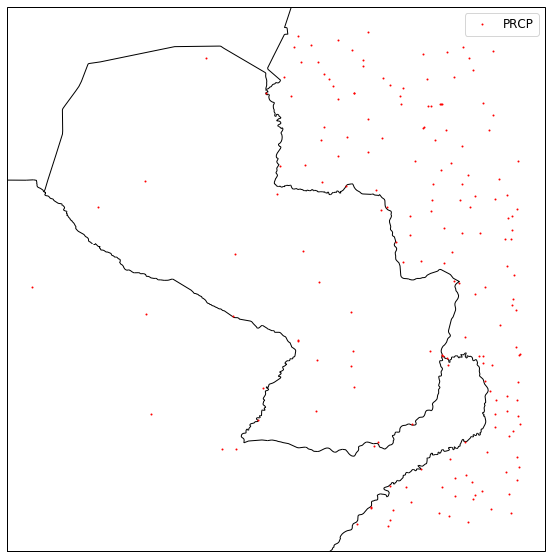

In [184]:
extract_data_GHC(selection='area',area=[-63,-53,-29,-19],variable='PRCP',path='G:/CLIMA/02_HYDRO-CLIMATE/GHC_Daily',
                 path_output='E:/BID_ASUNCION/Clima/Datos_Instrumentales/GHC_Daily/',
                 country='Paraguay',export=True)